# Time Series Forecasting with Python
Time series forecasting is the process of using historical data to predict future values of a time-dependent variable. This type of forecasting is based on the idea that past behavior and trends in the data can be used to make educated guesses about future values.

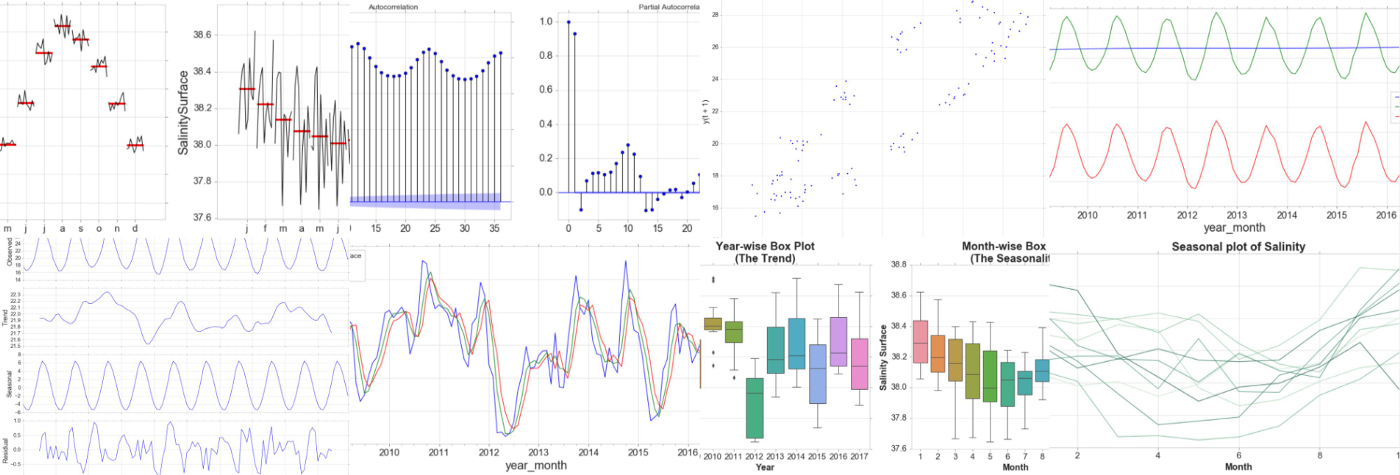

Many disciplines, such as finance, public administration, energy, retail, and healthcare, are dominated by time-series data. Large areas of micro- and macroeconomics rely on applied statistics with an emphasis on time-series analyses and
modeling. The following are examples of time-series data:
* Daily closing values of a stock index
* Number of weekly infections of a disease
* Weekly series of train accidents
* Rainfall per day
* Sensor data such as temperature measurements per hour
* Population growth per year
* Quarterly earnings of a company over a number of years

# Import Libraries

In [1]:
import itertools    # for grid search
import matplotlib.pyplot as plt  # for plotting graphs
import numpy as np         # for mathematical calculations
import pandas as pd     # for data manipulation
import statsmodels.api as sm        # for statistical models
from sklearn.metrics import mean_absolute_error # for evaluating models
from statsmodels.tsa.holtwinters import ExponentialSmoothing        # for Holt-Winters Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing      # for Simple Exponential Smoothing
from statsmodels.tsa.seasonal import seasonal_decompose     # for seasonal decomposition
import statsmodels.tsa.api as smt       # for statistical tests
import warnings     # for ignoring warnings
warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas()        # 1958-03-01 - 2001-12-01
y = data.data                         # 1958-03-01 - 2001-12-01
y = y['co2'].resample('MS').mean()  # Monthly Mean

In [3]:
y.isnull().sum()

5

In [4]:
y = y.fillna(y.bfill())     # Backward Fill

In [5]:
y.describe()

count    526.000000
mean     339.624826
std       17.110954
min      313.400000
25%      324.025000
50%      337.912500
75%      354.537500
max      373.800000
Name: co2, dtype: float64

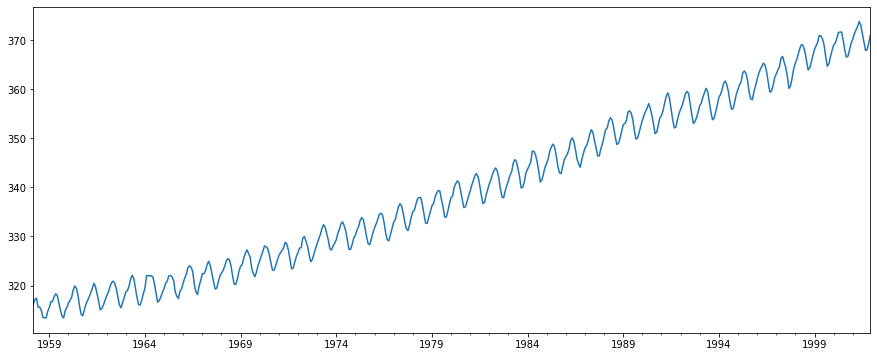

In [6]:
y.plot(figsize=(15, 6))
plt.show()

# Holdout

In [7]:
train = y[:'1997-12-01']        # 1958-03-01 - 1997-12-01
len(train)  

478

In [8]:
test = y['1998-01-01':]     # 1998-01-01 - 2001-12-01
len(test) 

48

# Time Series Structural Analysis

**Dickey-Fuller Test**

In [9]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


**Time Series Components and Stationarity Test**

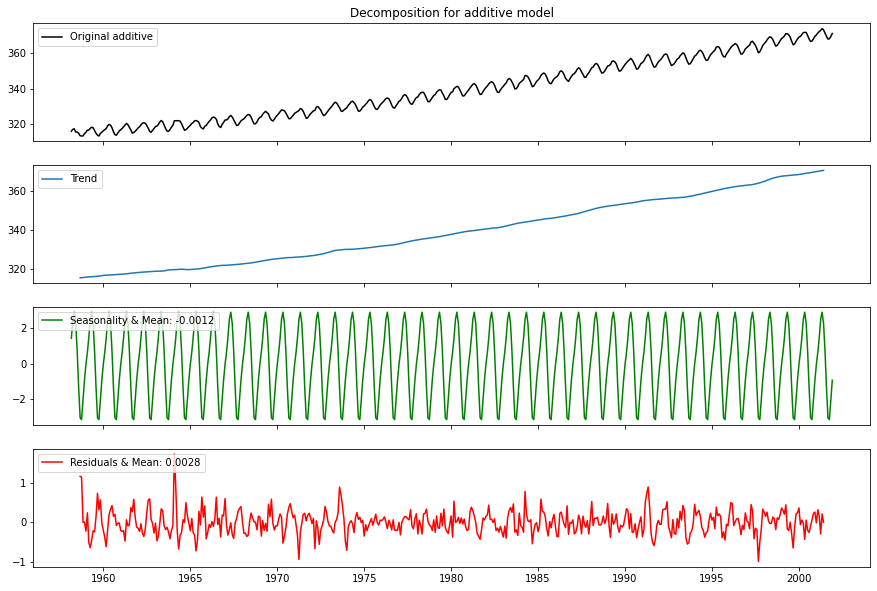

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [10]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(y, stationary=True)

# Single Exponential Smoothing

In [11]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(48)

mean_absolute_error(test, y_pred)

5.706393369643809

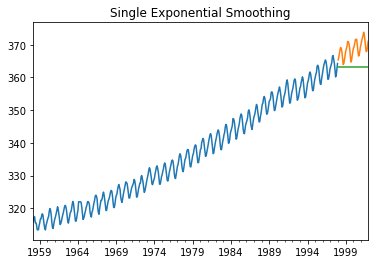

In [12]:
train.plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

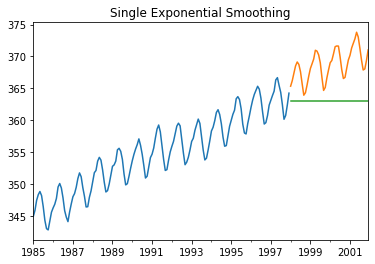

In [13]:
train["1985":].plot(title="Single Exponential Smoothing")
test.plot()
y_pred.plot()
plt.show()

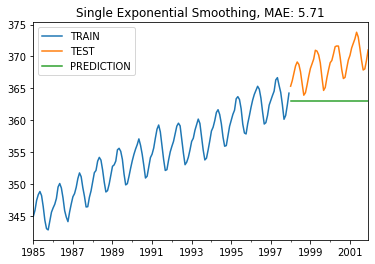

In [14]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [15]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.4419309772571,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Hyperparameter Optimization for SES

In [16]:
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)

ses_optimizer(train, alphas)

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451
alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.

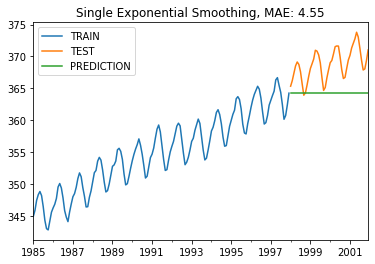

In [17]:
# Final SES Model

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

# Double Exponential Smoothing (DES)

Double Exponential Smoothing, also known as Holt's method, is a time series forecasting technique that extends simple exponential smoothing by adding a trend component to the forecast model. It is used to handle time series data with a trend, such as sales data with an upward or downward trend over time. The method models the data as a combination of a level and a trend component. The level component captures the average value of the data, and the trend component captures changes in the level over time. The method uses a weighted average of the past values and the trend to make predictions for future time steps. The weighting factors are determined by two smoothing parameters, alpha and beta, which control the weight given to the past values and the trend, respectively. The method can be implemented in a variety of ways, including simple exponential smoothing with a trend, and Holt-Winters with a seasonal period of 1.

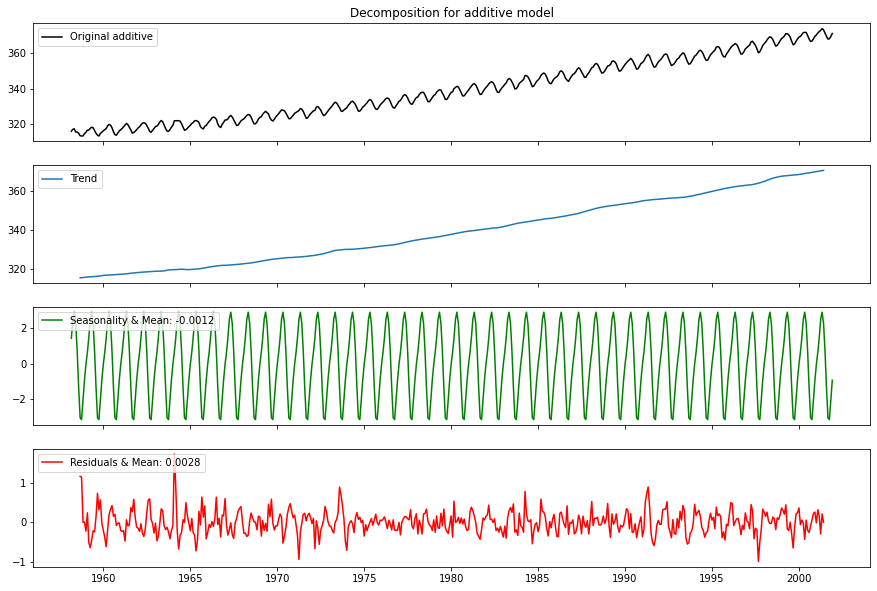

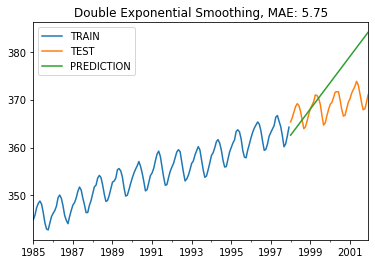

In [18]:
# DES: Level (SES) + Trend

# y(t) = Level + Trend + Seasonality + Noise
# y(t) = Level * Trend * Seasonality * Noise

ts_decompose(y)

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,
                                                         smoothing_trend=0.5)

y_pred = des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

In [19]:
des_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': 0.5,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 317.5299919184764,
 'initial_trend': -0.3037511835408627,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Hyperparameter Optimization for DES

In [20]:
def des_optimizer(train, test, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print(f"alpha: {round(alpha, 2)}, beta: {round(beta, 2)}, mae: {round(mae, 4)}")
    print(f"best_alpha: {round(best_alpha, 2)}, best_beta: {round(best_beta, 2)}, best_mae: {round(best_mae, 4)}")
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, test, alphas, betas)

alpha: 0.01, beta: 0.01, mae: 2.3849
alpha: 0.01, beta: 0.11, mae: 2.8294
alpha: 0.01, beta: 0.21, mae: 2.744
alpha: 0.01, beta: 0.31, mae: 2.1723
alpha: 0.01, beta: 0.41, mae: 2.8895
alpha: 0.01, beta: 0.51, mae: 2.49
alpha: 0.01, beta: 0.61, mae: 1.8196
alpha: 0.01, beta: 0.71, mae: 1.7411
alpha: 0.01, beta: 0.81, mae: 2.1932
alpha: 0.01, beta: 0.91, mae: 4.8521
alpha: 0.11, beta: 0.01, mae: 2.4334
alpha: 0.11, beta: 0.11, mae: 3.9118
alpha: 0.11, beta: 0.21, mae: 6.0908
alpha: 0.11, beta: 0.31, mae: 7.2434
alpha: 0.11, beta: 0.41, mae: 8.7305
alpha: 0.11, beta: 0.51, mae: 10.3166
alpha: 0.11, beta: 0.61, mae: 12.0066
alpha: 0.11, beta: 0.71, mae: 13.9772
alpha: 0.11, beta: 0.81, mae: 16.4873
alpha: 0.11, beta: 0.91, mae: 19.655
alpha: 0.21, beta: 0.01, mae: 2.8218
alpha: 0.21, beta: 0.11, mae: 5.7217
alpha: 0.21, beta: 0.21, mae: 8.6538
alpha: 0.21, beta: 0.31, mae: 11.7598
alpha: 0.21, beta: 0.41, mae: 15.5277
alpha: 0.21, beta: 0.51, mae: 20.1474
alpha: 0.21, beta: 0.61, mae: 25.5

# Final DES Model

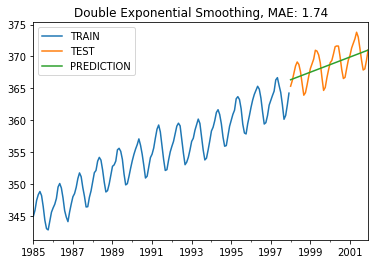

In [21]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

# Triple Exponential Smoothing (Holt-Winters)

Triple Exponential Smoothing, also known as the Holt-Winters method, is a time series forecasting technique that extends exponential smoothing by adding a seasonal component to the forecast model. It is used to handle time series data with a trend and seasonality, such as monthly sales data with a consistent upward trend and a repeating seasonal pattern from year to year. The method models the data as a combination of a level, trend, and seasonality component. The level component captures the average value of the data, the trend component captures changes in the level over time, and the seasonality component captures repeating patterns in the data. The method uses a weighted average of the past values, level, and trend, to make predictions for future time steps.

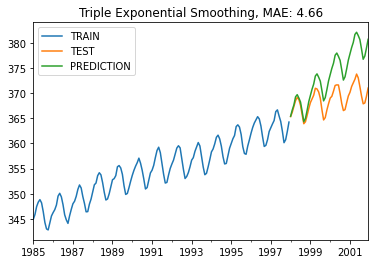

In [22]:
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

y_pred = tes_model.forecast(48)
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

# Hyperparameter Optimization for TES

In [23]:
alphas = betas = gammas = np.arange(0.20, 1, 0.10)

abg = list(itertools.product(alphas, betas, gammas))


def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.2, 0.9, 0.71]
[0.2, 0.3, 0.2, 0.86]
[0.2, 0.3, 0.3, 0.93]
[0.2, 0.3, 0.4, 0.94]
[0.2, 0.3, 0.5, 0.95]
[0.2, 0.3, 0.6, 1.09]
[0.2, 0.3, 0.7, 1.43]
[0.2, 0.3, 0.8, 1.95]
[0.2, 0.3, 0.9, 1.73]
[0.2, 0.4, 0.2, 1.63]
[0.2, 0.4, 0.3, 1.74]
[0.2, 0.4, 0.4, 1.64]
[0.2, 0.4, 0.5, 1.68]
[0.2, 0.4, 0.6, 2.3]
[0.2, 0.4, 0.7, 4.39]
[0.2, 0.4, 0.8, 11.66]
[0.2, 0.4, 0.9, 4.52]
[0.2, 0.5, 0.2, 2.46]
[0.2, 0.5, 0.3, 2.52]
[0.2, 0.5, 0.4, 1.94]
[0.2, 0.5, 0.5, 1.82]
[0.2, 0.5, 0.6, 1.84]
[0.2, 0.5, 0.7, 3.35]
[0.2, 0.5, 0.8, 4.63]
[0.2, 0.5, 0.9, 3.99]
[0.2, 0.6, 0.2, 3.37]
[0.2, 0.6, 0.3, 3.11]
[0.2, 0.6, 0.4, 0.72]
[0.2, 0.6, 0.5, 1.08]
[0.2, 0.6, 0.6, 1.64]
[0.2, 0.6, 0.7, 2.68]
[0.2, 0.6, 0.8, 8327.83]
[0.2, 0.6, 0.9, 151797145264.8]
[0.2, 0.7, 0.2, 4.72]
[0.2, 0.7, 0.3, 4.56]
[0.2, 0.7, 0.4, 6.58]
[0.2, 0.7, 0.5, 0.64]
[0.2, 0.7, 0.6, 1.9

# Final TES Model

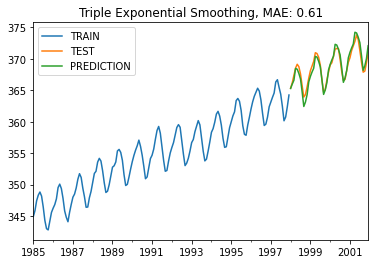

In [24]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

# Model Comparison

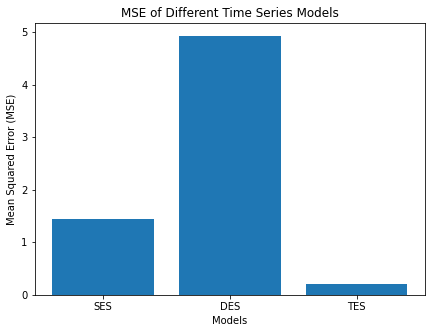

In [25]:
model_names = ["SES", "DES", "TES"]
model_mse = [round(np.mean((ses_model.resid)**2), 4),             
             round(np.mean((des_model.resid)**2), 4),             
             round(np.mean((tes_model.resid)**2), 4)]

plt.figure(figsize=(7, 5))
plt.bar(model_names, model_mse)
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of Different Time Series Models')
plt.show()

# Conclusion
Time series forecasting is a powerful tool for organizations in a variety of industries. By using historical data to make predictions about future trends, organizations can make informed decisions and allocate resources effectively. There are many different types of time series forecasting models, ranging from simple methods to more complex models, and the choice of method will depend on the characteristics of the data and the goals of the problem. With the right tools and techniques, time series forecasting can provide valuable insights into future trends and help organizations plan for the future.

There are many resources available for learning about time series forecasting and how to perform it using Python. Here are a few recommended references:

* Time Series Forecasting in Python-by Marco Peixeiro
* Time Series Analysis with Python Cookbook: Practical Recipes for Exploratory Data Analysis, Data Preparation, Forecasting, and Model Evaluation-by Tarek A. Atwan
* Python for Time Series Data Analysis by Travis Mahoney
* Time Series Analysis and Forecasting with Python by Dr. PKS Prakash
* Hands-On Time Series Analysis with R by Vishwanathan N
* Time Series Analysis and Its Applications: With R Examples by Robert H. Shumway, David S. Stoffer

# References 

1. https://www.miuul.com/zaman-serileri